# Simple AM model for mTSP environment

We take the same environment as in the previous notebook, but now we use a simple AM model to solve the problem.

### Changes compared to AM model

No change actually! We can use RL4CO's modularity, and basically change nothing except adding

- Context
- Initial embedding
- (Dynamic embedding? works but not sure if it's necessary)

for the mTSP environment.

> NOTE: I am not sure if this is correct; there may be some stupid mistake. I don't have a reference implementation for mTSP, nor how to do make the above for it. So this is totally a free-style implementation lol

Please check out if this is correct and let me know if you find any mistake! :)

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union, Any
from einops import rearrange, repeat
from hydra.utils import instantiate
from omegaconf import OmegaConf, DictConfig

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L

from rl4co.utils.ops import batchify, unbatchify
from rl4co.envs import MTSPEnv
from rl4co.models.rl.reinforce import RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load environment and plot random solutions

In [2]:
def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    # reward = env.get_reward(td, actions)
    # td.set("reward", reward)
    td.set("action", actions)
    return td

tensor([[-3.9100],
        [-5.3626]])


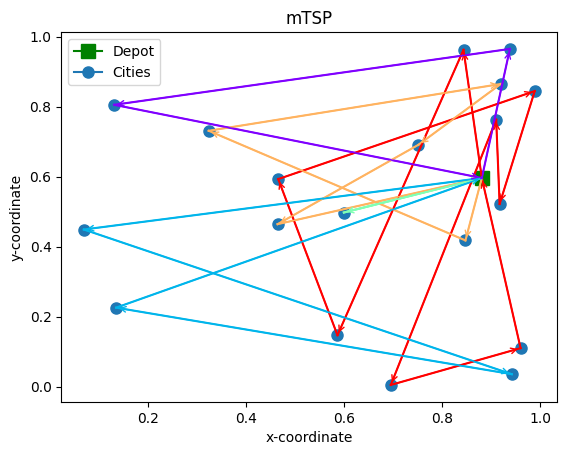

In [3]:
env = MTSPEnv(num_loc=20, min_num_agents=5, max_num_agents=5, cost_type="minmax")

td = env.reset(batch_size=[2])
td = rollout(env, td, random_policy)
print(td["reward"])

env.render(td)

## Test AM policy

In [4]:
from rich.traceback import install
install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f1377297bb0>>

In [5]:
# Load environment with test data
env = MTSPEnv(num_loc=20, min_num_agents=5, max_num_agents=5, cost_type="minmax")

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

policy = AttentionModelPolicy(
    env,
).to("cuda")

# model = torch.compile(model)

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling")

print(out)

{'reward': tensor([ -5.2078,  -5.3665,  -4.7705,  -9.1884,  -5.4395,  -6.1202,  -4.6770,
         -5.6368,  -4.4969,  -3.2963,  -7.1617,  -2.7812,  -6.5189,  -5.6867,
         -9.2399,  -4.4504,  -4.8476,  -4.1691,  -4.2081,  -5.2756,  -5.1008,
         -5.4684,  -4.7364,  -8.3585,  -4.6620,  -6.0555,  -3.4810,  -3.3973,
         -4.0481,  -4.0781,  -3.0187,  -6.5024,  -3.7856,  -9.2513,  -7.3484,
         -3.6673,  -4.3804,  -4.6720,  -3.1373,  -5.5839,  -3.0903,  -6.9735,
         -9.0805,  -5.7680, -10.0343,  -6.5626,  -6.2539,  -9.7539,  -3.4943,
         -3.9228,  -8.4163,  -6.3537,  -6.7415, -10.3316,  -6.4367,  -5.3017,
         -5.9358,  -7.9250,  -6.0175,  -3.4832,  -5.2980,  -6.1391,  -4.1408,
         -6.6117], device='cuda:0'), 'log_likelihood': tensor([-48.6846, -42.7089, -37.8677, -43.6395, -39.6454, -42.3383, -39.6039,
        -38.1323, -38.7480, -45.1440, -40.8265, -44.2330, -41.5203, -42.7250,
        -41.5482, -45.1350, -39.7158, -44.2099, -42.8334, -37.1375, -40.7187

## Create full AM: `env` + `policy` + `baseline`

In [6]:
# baseline = WarmupBaseline(RolloutBaseline()) # don't know why this one makes training worse here at times
baseline = ExponentialBaseline(0.8)

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([ -9.8885,  -5.5803,  -3.8836, -11.1545,  -4.1730,  -5.6615,  -6.2491,
         -4.5223,  -7.6813,  -4.2707,  -5.9432,  -4.1076,  -5.8704, -11.5324,
        -11.6547,  -3.4162,  -9.5772,  -5.5829,  -3.4210,  -5.8738,  -4.4755,
         -5.6915,  -3.9991,  -8.2714,  -7.4082, -11.2305,  -4.8260,  -5.5104,
         -4.9081,  -5.8921,  -3.6972,  -6.5586,  -3.7572, -10.6464,  -5.0862,
         -2.8446,  -4.6351,  -4.4904,  -4.1918,  -3.6344,  -2.8608,  -3.5895,
         -5.1363,  -4.4196, -10.1988,  -4.1963,  -5.7303, -11.5499,  -4.2226,
        -10.1625,  -9.5224,  -4.6857,  -5.2175,  -3.7234, -10.3709,  -4.7556,
         -3.2757,  -8.3718,  -3.0159,  -7.7829,  -4.0400,  -6.7401,  -4.8321,
         -2.9666], device='cuda:0'), 'log_likelihood': tensor([-41.0724, -43.4243, -40.8716, -41.2718, -45.3956, -45.9775, -42.1054,
        -39.7473, -43.5659, -46.7221, -40.2104, -40.3038, -43.5638, -38.5248,
        -40.1780, -45.2579, -35.8124, -43.5973, -42.5920, -41.7740, -43.9337

## Lightning module

In [7]:
class RL4COLitModule(L.LightningModule):
    def __init__(self, env, model, cfg):
        """
        Base LightningModule for Neural Combinatorial Optimization
        If model_cfg is passed, it will take precedence over cfg.model
        Likewise for env_cfg
        
        NOTE: simplified not to use Hydra instantiate here
        """

        super().__init__()
        # this line ensures params passed to LightningModule will be saved to ckpt
        # it also allows to access params with 'self.hparams' attribute
        self.save_hyperparameters(cfg)
        self.cfg = cfg
        self.env = env
        self.model = model
        self.instantiate_metrics()

    def instantiate_metrics(self):
        """Dictionary of metrics to be logged at each phase"""
        self.train_metrics = self.cfg.metrics.get("train", ["loss", "reward"])
        self.val_metrics = self.cfg.metrics.get("val", ["reward"])
        self.test_metrics = self.cfg.metrics.get("test", ["reward"])
        self.log_on_step = self.cfg.metrics.get("log_on_step", True)

    def setup(self, stage="fit"):
        self.train_dataset = self.env.dataset(self.cfg.data.train_size, "train")
        self.val_dataset = self.env.dataset(self.cfg.data.val_size, "val")
        test_size = self.cfg.data.get("test_size", self.cfg.data.val_size)
        self.test_dataset = self.env.dataset(test_size, "test")
        if hasattr(self.model, "setup"):
            self.model.setup(self)

    def configure_optimizers(self):
        parameters = (
            self.parameters()
        )  # this will train task specific parameters such as Retrieval head for AAN
        optimizer = torch.optim.Adam(
            parameters, lr=self.cfg.optim.lr, weight_decay=self.cfg.optim.weight_decay
        )
        return [optimizer] # NOTE: for simplicity we do not include the scheduler here
    
    def shared_step(self, batch: Any, batch_idx: int, phase: str):
        td = self.env.reset(batch)
        out = self.model(td, phase)
        # Log metrics
        metrics = getattr(self, f"{phase}_metrics")
        metrics = {f"{phase}/{k}": v.mean() for k, v in out.items() if k in metrics}
        self.log_dict(
            metrics,
            on_step=self.log_on_step,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )

        return {"loss": out.get("loss", None)}

    def training_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="train")

    def validation_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="val")

    def test_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="test")

    def train_dataloader(self):
        return self._dataloader(self.train_dataset)

    def val_dataloader(self):
        return self._dataloader(self.val_dataset)
    
    def test_dataloader(self):
        return self._dataloader(self.test_dataset)

    def on_train_epoch_end(self):
        if hasattr(self.model, "on_train_epoch_end"):
            self.model.on_train_epoch_end(self)
        self.train_dataset = self.env.dataset(self.cfg.data.train_size, "train")

    def _dataloader(self, dataset):
        return DataLoader(
            dataset,
            batch_size=self.cfg.data.batch_size,
            shuffle=False,  # no need to shuffle, we're resampling every epoch
            num_workers=self.cfg.data.get("num_workers", 0),
            collate_fn=TensorDictCollate(),
        )


## Configuration

In [8]:
config = DictConfig(
    {
        "data": {
            "train_size": 100000, # with 1 epochs, this is 1k samples
            "val_size": 10000, 
            "batch_size": 512,
        },
        "optim": {
            "lr": 1e-4,
            "weight_decay": 1e-5,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)


lit_module = RL4COLitModule(env, model, config)

## Fit model

Let's train for few epochs to see if it works

In [9]:
# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0#1.0, # clip gradients to avoid exploding gradients!
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | MTSPEnv        | 0     
1 | model | AttentionModel | 710 K 
-----------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.844     Total estimated model params size (MB)
2023-05-15 23:47:16.474677: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 23:47:16.494063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 196/196 [00:08<00:00, 22.34it/s, v_num=49, train/reward_step=-1.34, train/loss_step=-.0847, val/reward_step=-1.30, val/reward_epoch=-1.29, train/reward_epoch=-1.34, train/loss_epoch=-.171] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s, v_num=49, train/reward_step=-1.34, train/loss_step=-.0847, val/reward_step=-1.30, val/reward_epoch=-1.29, train/reward_epoch=-1.34, train/loss_epoch=-.171]


## Testing

In [10]:
trainer.test(lit_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 46.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/reward_epoch     │    -1.2895160913467407    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward_epoch': -1.2895160913467407}]

## Decode with sampling

In [11]:
policy = lit_module.model.policy
policy = policy.eval().to("cuda")

test_dataloader = lit_module.test_dataloader()

td = next(iter(test_dataloader)).to("cuda")[:32]
td = env.reset(td)

# Greedy sampling
# out = policy(td, decode_type="greedy", return_actions=True)
# Sampling with multiple samples
td_sampling = batchify(td, 128)
out = policy(td_sampling, decode_type="sampling", return_actions=True, softmax_temp=1) 

reward = out.get('reward')
actions = out.get('actions')
reward = unbatchify(reward, 128)
actions = unbatchify(actions, 128)

# Get argmax of reward on dim = 1
best_rewards, best_idx = torch.max(reward, dim=1)
best_actions = torch.gather(actions, 1, best_idx[:, None, None].repeat(1, 1, actions.shape[-1])).squeeze(1)


td = td.detach().cpu()
td.set('action', best_actions)
td.set('reward', best_rewards)
print(torch.mean(best_rewards))

tensor(-1.1536, device='cuda:0')


Cost: 1.094


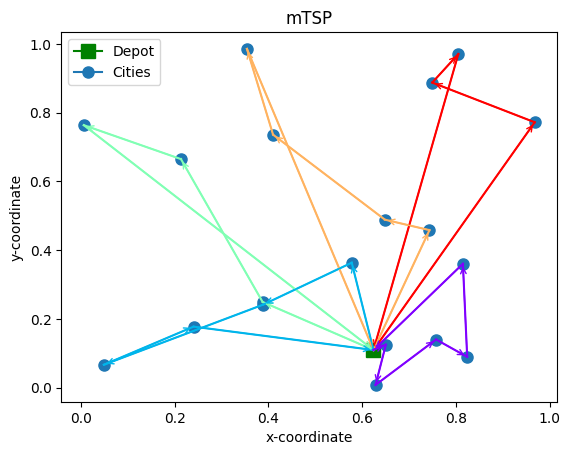

Cost: 1.359


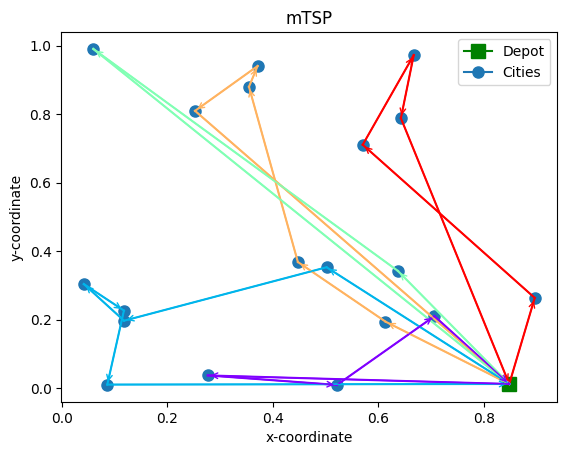

Cost: 1.038


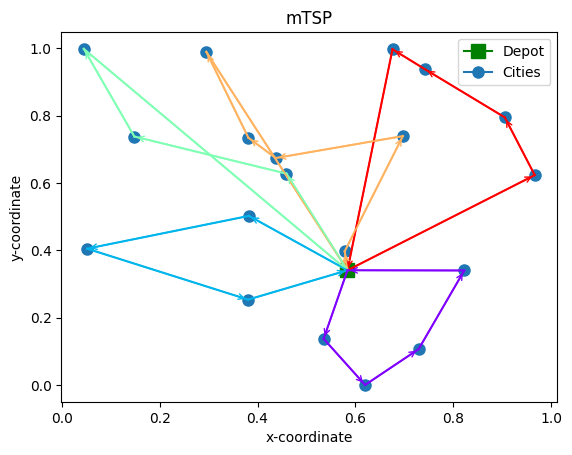

Cost: 1.131


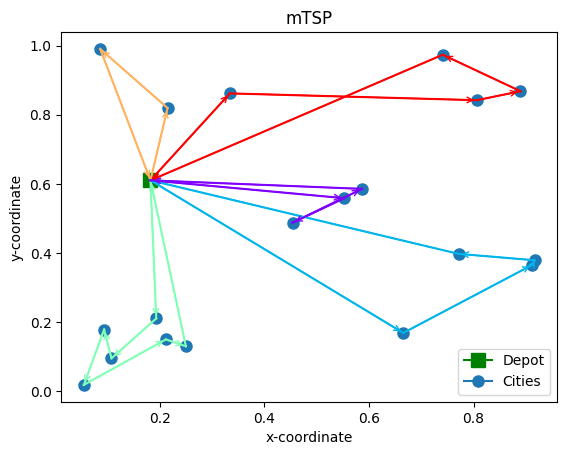

Cost: 1.316


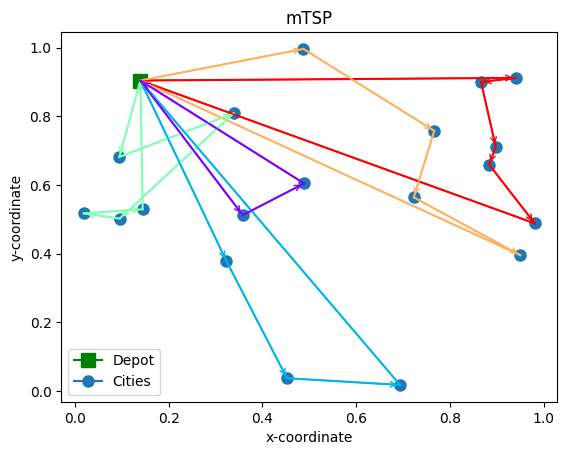

Cost: 1.217


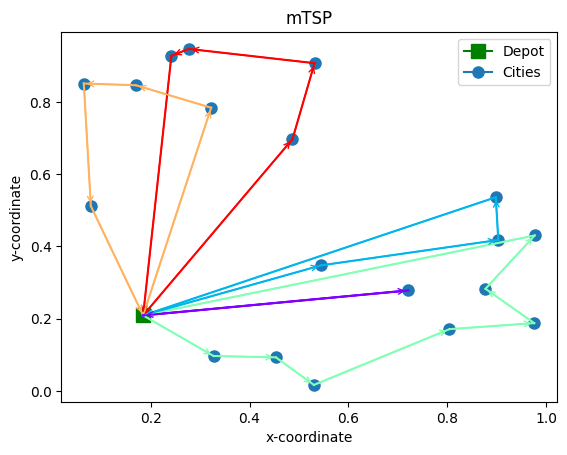

Cost: 1.103


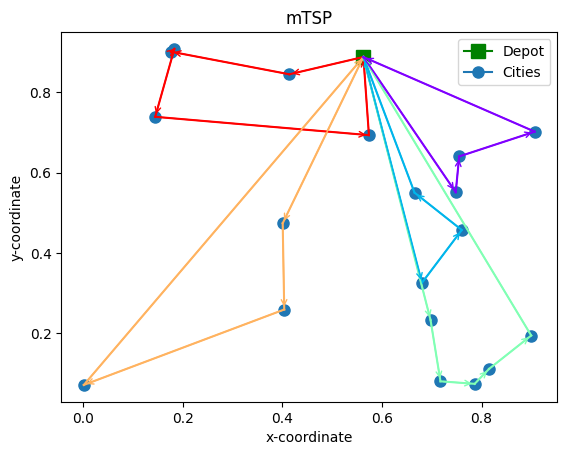

Cost: 0.918


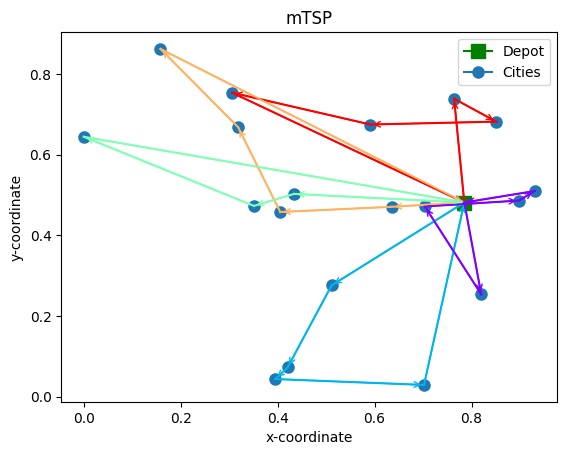

Cost: 1.077


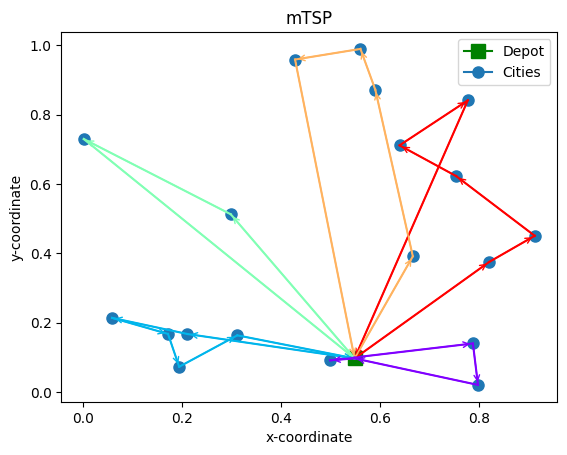

Cost: 1.478


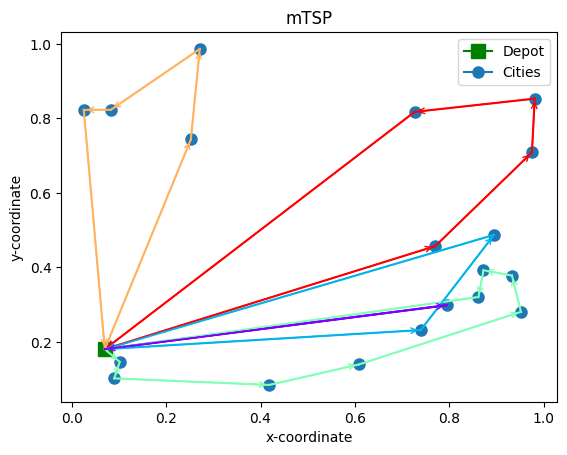

In [12]:
# Plot 10 solutions
for i in range(10):
    print("Cost: {:.3f}".format(-td[i].get("reward")))
    env.render(td[i:i+1])